<h2>Segmenting Facial Orientation using IsoMap</h2>
<p>In this notebook, we aim to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000). This improved dimensionality reduction method corrects many of the problems with PCA and MultiDimensional Scaling while maintaining their key strengths such as computational efficency, global optimiality, and asymtotic convergence. In contrast to PCA and MDS, the isomap algorithim enables the learning of more flexible manifolds both linear and non-linear. This method of dimensionality reduction thus is particularly sucessful in applications where the dataset naturally contains a non-linear structure. Such non-lienar structure is invisible to PCA and MDS due to their focus on solely ecludian distances, which isomap addresses by utilizing an altered version of MDS that seeks to "perserve the intrensic geometry of data as captured in the geodisc manifold distances between all pairs of points" (Tenebaum). But what does this type of distance metric look like? From a simplified perspective, Geodesic distance is a way of measuring the distance between two verticies via a shortest path or "arc" between two points. Ideally, we would like to estimate this distance for points that are inheretly close in high dimensional space, but low in lower dimensional space. Because these verticies are far away in low dimensional space, we much begin by finding nearest neightbors to the start point in low dimensional space and "hopping" to neightbors repeatedly until we reach the final vertex in low dimensional space. This path which was created by low dimensional "hops" will thus follow the local structure of the dataset through it outset thus perserving the global structure as well. The algorithm itself involves three primary steps:</p>

- Constructing the Neighborhood Graph 
- Computing the Shortest Paths for our Neighborhoods
- Construct a $d$ Dimensional Embedding of these paths


In the code below we will implement isomap from scratch and recreate some of the foundational examples of this algorithim initial coded by the papers' authors.



---

First, we begin by loading a few neccecary libraries:

- Numpy: This libaray provides all of the array and vectorization functionality we will use in implementing our isomap function in a comutational and memory efficent way.
- Networkx: This library is designed to more efficently implement a graphical datastructure. This library is espeically important for use in computing our shortest path distances.
- Matplotlib: This library is utilzied for all of our visualization needs in python.
- Scipy.io: This library offers some utility functions for io operations. More specifically, we will use this library to load matlab datafiles. 
- Pillow: This library is a utility for many image related io operations.
- Sklearn: This library provides both alot of utility and machine learning functions for use in python. We will use Sklearns default implementation of PCA for comparison with our custom isomap function



In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import kneighbors_graph,NearestNeighbors
from scipy.sparse.csgraph import shortest_path

Next we will load in our facial dataset. This file isomap.mat contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 $\times$ 64 luminosity map, hence represented as a vector in $\mathbb R^{4096}$. Because we are using python with a matlab datafile sometimes images get messy on import. Below we will apply a few reshaping operations so that our images are oriented and shaped correctly.


In [2]:
images = scipy.io.loadmat('faces.mat')['images']
images = np.reshape(images,(64,64,698))
images = np.rot90(images,k=3,axes=(0,1))
print(f'Images Shape = {images.shape}')

Images Shape = (64, 64, 698)


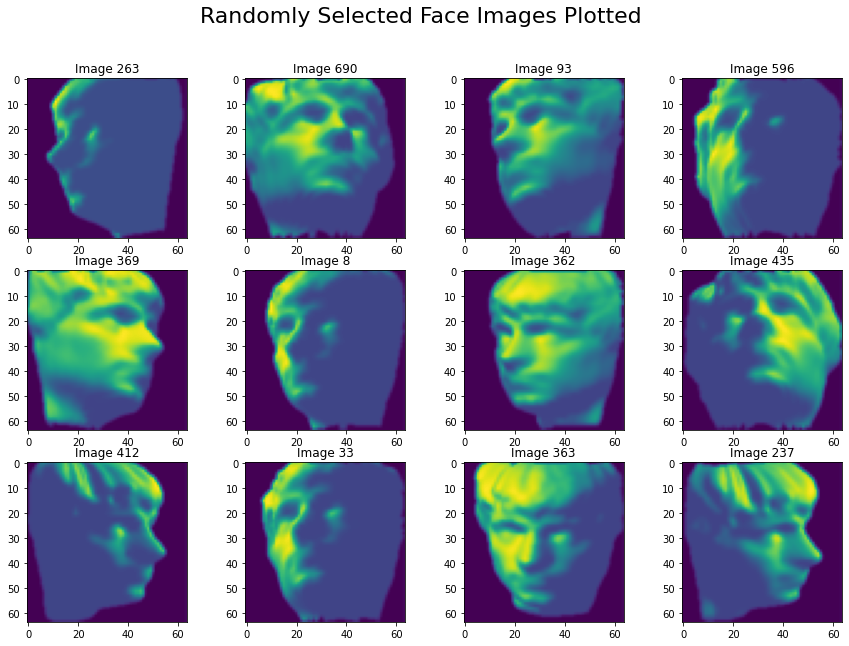

In [3]:
image_plot_rows = 3
image_plot_cols = 4
fig,axs = plt.subplots(image_plot_rows,image_plot_cols,figsize=(15,10))
for i in range(0,image_plot_rows):
    for j in range(0,image_plot_cols):
        ax_i = axs[i,j]
        rand_image_idx_i = np.random.randint(0,images.shape[2])
        ax_i.imshow(images[:,:,rand_image_idx_i])
        ax_i.set_title(f'Image {rand_image_idx_i}')
fig.suptitle('Randomly Selected Face Images Plotted',fontsize=22)
plt.show()

Now that we have verified that our face images are plotting correctly we use the code cell below to convert to a 2D representation where each sample image will be represented by a column vector.

In [4]:
images_array = scipy.io.loadmat('faces.mat')['images'].T
print(f'Images Array Shape = {images_array.shape}')

Images Array Shape = (698, 4096)


Now that our dataset has been loaded properly, we also create some synthetic data below based on a "swiss-roll" pattern. This data is generated for illustrations purposes of the shortest path distance and why it improves upon ecludian. Additionally, we use it as a prime case as to how isomap outperforms standard PCA. 

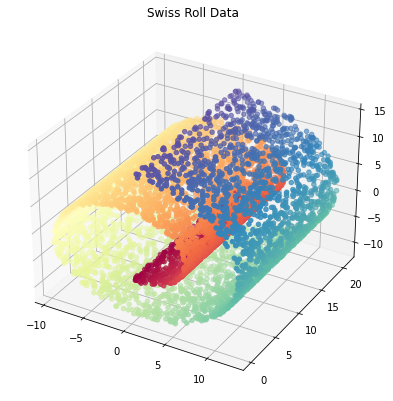

In [9]:
swiss_X, swiss_color = datasets.make_swiss_roll(n_samples=7000)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(211, projection="3d")
ax.scatter(swiss_X[:, 0], swiss_X[:, 1], swiss_X[:, 2], c=swiss_color, cmap=plt.cm.Spectral)
plt.title("Swiss Roll Data")
plt.show()

With our data and libraries loaded, we will now create some custom utility functions that will help seperate the implementation steps of our isomap function. The first of these utilities is our shortest path function.

Our next utiilty function to define will be used to create our centering matrix

In [10]:
def generate_centering_matrix(path_matrix):
    n = path_matrix.shape[0]
    centering_matrix = np.eye(n) - 1/n*np.ones((n,1)).dot(np.ones((n,1)).T)
    return centering_matrix

Our next utility function will be the $\tau$ operator function specified by the isomap paper which is used to convert distances to inner products.

In [11]:
def Tau_Operator(D,centering_matrix):
    D_squared = D**2.0
    C = -0.5*centering_matrix@D_squared@centering_matrix
    return C

Our next utility function will be responsible for constructing the embedding for our data. Taking as input, the output from the $\tau$ operator, this function will compute and sort the eigenvalues of this matrix then compute our embedded dimensional coordinate vector.

In [12]:
def Generate_Embedding(centered_distance_matrix,k=2):
    U,Sigma,V = np.linalg.svd(centered_distance_matrix)
    VT_k = V[0:k,:].T
    Sigma_k_root = np.sqrt(Sigma[0:k])
    Z =VT_k@np.diag(Sigma_k_root)
    return Z

Now lets put all of these functions together under one wrapper function called isomap.

In [13]:
def IsoMap(data,distance_metric='euclidean',k=6,embedding_dim=2):
    k_neighbors = NearestNeighbors(n_neighbors=k-1,n_jobs=-1,metric=distance_metric).fit(data)
    k_neighbors_graph = kneighbors_graph(k_neighbors,n_neighbors=k-1,metric=distance_metric,mode="distance",n_jobs=-1)
    paths = shortest_path(k_neighbors_graph,directed=False)
    centering_matrix = generate_centering_matrix(paths)
    centered_distance_matrix = Tau_Operator(paths,centering_matrix)
    embedding = Generate_Embedding(centered_distance_matrix,k=embedding_dim)
    return embedding

In [14]:
Z_L1 = IsoMap(images_array,distance_metric='cityblock',k=6,embedding_dim=2)
Z_L2 = IsoMap(images_array,distance_metric='euclidean',k=6,embedding_dim=2)

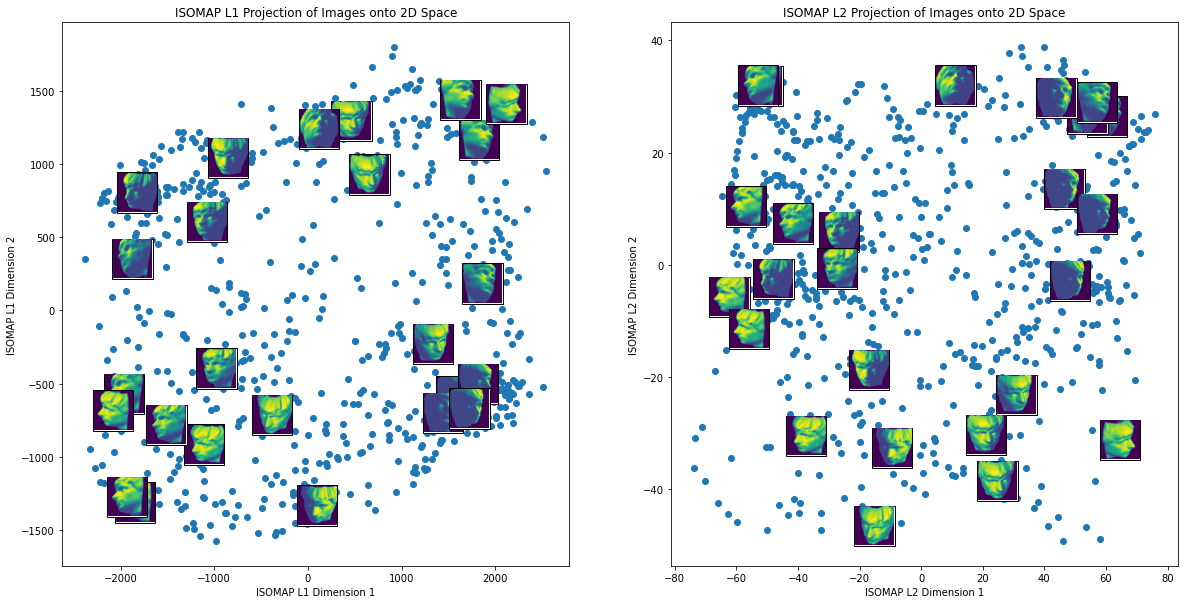

In [15]:
images_album = np.reshape(images_array,(698,64,64))
images_album_index = np.random.randint(0,images_album.shape[2],size=30)

fig, axs = plt.subplots(1,2,figsize=(20,10))
ax1 = axs[0]
ax2 = axs[1]
ax1.scatter(Z_L1[:,0], Z_L1[:,1])
ax1.set_title('ISOMAP L1 Projection of Images onto 2D Space')
ax1.set_xlabel('ISOMAP L1 Dimension 1')
ax1.set_ylabel('ISOMAP L1 Dimension 2')
for i in images_album_index:
    solo_image = images_album[i,:,:].T
    imagebox = OffsetImage(solo_image, zoom=0.6)
    ab = AnnotationBbox(imagebox, Z_L1[i,:], pad=0.1)
    ax1.add_artist(ab)
    
ax2.scatter(Z_L2[:,0], Z_L2[:,1])
ax2.set_title('ISOMAP L2 Projection of Images onto 2D Space')
ax2.set_xlabel('ISOMAP L2 Dimension 1')
ax2.set_ylabel('ISOMAP L2 Dimension 2')
for i in images_album_index:
    solo_image = images_album[i,:,:].T
    imagebox = OffsetImage(solo_image, zoom=0.6)
    ab = AnnotationBbox(imagebox, Z_L2[i,:], pad=0.1)
    ax2.add_artist(ab)
plt.show()


Using the above D matrix and following the proper Isomap formula implementation in solving for our reduced dimensional embedding’s, we arrive at the following visualization:

In [16]:
Z_swiss = IsoMap(swiss_X,distance_metric='euclidean',k=6,embedding_dim=2)

In [17]:
Z_swiss_1 = Z_swiss[:,0]
Z_swiss_2 = Z_swiss[:,1]

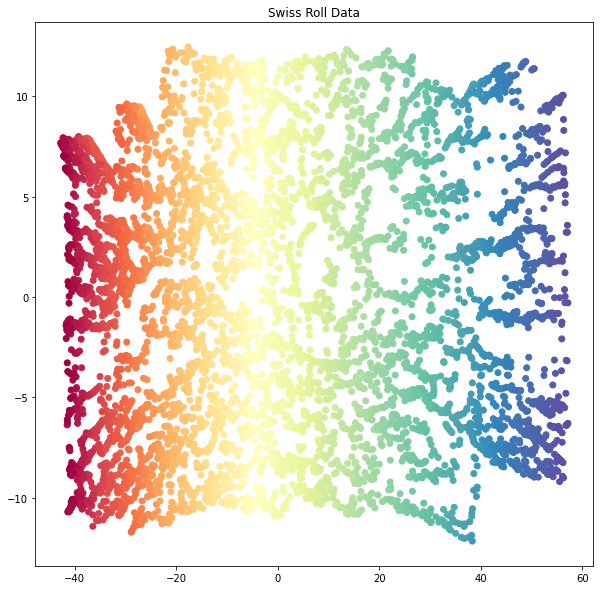

In [18]:
fig = plt.figure(figsize=(10,10))
plt.scatter(Z_swiss_1,Z_swiss_2, c=swiss_color, cmap=plt.cm.Spectral)
plt.title("Swiss Roll Data")
plt.show()